<font size=7 color ="#5499C7" >Audio MNIST</font>
- <font size=5>__Done By__ : Kasra Noorbakhsh</font>
- <font size=5>__UID__  : 810100230</font>
- <font size=5>__Goal__  : Digit and Speaker Recognition</font>
- <font size=5>__Dataset Path__  : ./data</font>

### <p align="justify"><font size="6" color="#d62b5b">Step 1: Initialization and Overview</font></p>
<p align="justify">

<p align="justify"><font size="6" color="#A9CCE3"><b>Section 0: Setup & imports</b></font><br></p>

In [11]:
import os
import json
import random
import librosa
import numpy as np
import pandas as pd
from glob import glob
import librosa.display
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# parameters
TARGET_SR = 16000
TARGET_LEN = TARGET_SR  # 1 second = 16000 samples
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 1024

# Paths
DATA_ROOT = "data"

# Check GPU (if using torch later)
try:
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Torch device:", device)
except Exception:
    device = None
    print("Torch not available in this environment")

Torch device: cpu


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 1: Gather file list & quick metadata</b></font></p>

In [12]:
rows = []
for speaker_folder in sorted(glob(os.path.join(DATA_ROOT, "*"))):
    speaker_id = os.path.basename(speaker_folder)
    if not speaker_id.isdigit(): 
        continue
    for wav_path in glob(os.path.join(speaker_folder, "*.wav")):
        fname = os.path.basename(wav_path)
        # Expect format: digit_speaker_iter.wav e.g. 0_04_20.wav
        parts = fname.replace(".wav","").split("_")
        if len(parts) < 3:
            # log weird filenames
            rows.append({"path": wav_path, "speaker": speaker_id, "digit": None, "iter": None, "flag_bad_name": True})
            continue
        digit = int(parts[0])
        speaker_code = parts[1]
        iteration = parts[2]
        rows.append({"path": wav_path, "speaker": speaker_id, "digit": digit, "iter": iteration, "flag_bad_name": False})

df = pd.DataFrame(rows)
print("Total files:", len(df))
print(df.head())

Total files: 30000
                  path speaker  digit iter  flag_bad_name
0   data\01\0_01_0.wav      01      0    0          False
1   data\01\0_01_1.wav      01      0    1          False
2  data\01\0_01_10.wav      01      0   10          False
3  data\01\0_01_11.wav      01      0   11          False
4  data\01\0_01_12.wav      01      0   12          False


#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 2: Durations and sample rate checks</b></font></p>

Sample rate(s) found (sample of files): {48000}
Duration stats (sample): mean=0.645 s, median=0.636 s, max=0.995 s


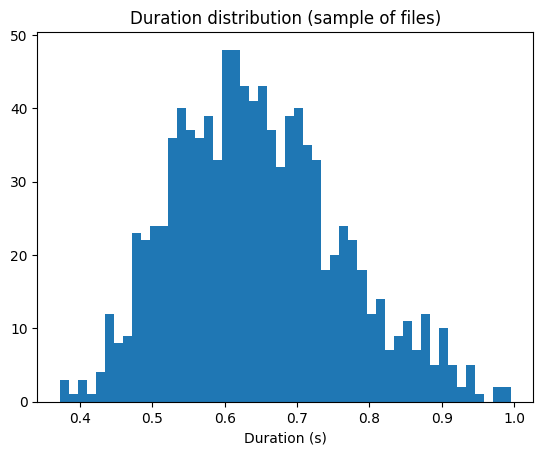

In [13]:
# Compute durations and sample rates for a sample files
# Warning: reading all files can take time. We'll sample 1000 files first, then optionally run full check.
sample_paths = df['path'].sample(min(1000, len(df)), random_state=RANDOM_SEED).tolist()

durations = []
sr_set = set()
for p in sample_paths:
    try:
        info = sf.info(p)
        sr_set.add(info.samplerate)
        durations.append(info.frames / info.samplerate)
    except Exception as e:
        print("Failed reading", p, e)

print("Sample rate(s) found (sample of files):", sr_set)
print("Duration stats (sample): mean=%.3f s, median=%.3f s, max=%.3f s" % (np.mean(durations), np.median(durations), np.max(durations)))

plt.hist(durations, bins=50)
plt.xlabel("Duration (s)")
plt.title("Duration distribution (sample of files)")
plt.show()

### <p align="justify"><font size="6" color="#d62b5b">Step 2: Data cleaning and preprocessing</font></p>
<p align="justify">

- Convert all audio to 16 kHz mono

- Normalize and trim/pad to 1 s

- Extract log-Mel spectrograms (128 Mel bins)

- Cache features for training

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 3: Preprocessing Functions</b></font></p>

In [14]:
def load_and_preprocess(path, target_sr=TARGET_SR, target_len=TARGET_LEN):
    y, sr = librosa.load(path, sr=None, mono=True)
    # Resample
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    # Normalize
    y = y / np.max(np.abs(y) + 1e-9)
    # Trim/pad to 1 s
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    elif len(y) > target_len:
        y = y[:target_len]
    return y, sr

def to_logmel(y, sr, n_mels=N_MELS, hop_length=HOP_LENGTH, n_fft=N_FFT):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    logmel = librosa.power_to_db(mel, ref=np.max)
    return logmel.astype(np.float32)

#### <p align="justify"><font size="6" color="#A9CCE3"><b>Section 4: Quick Visual Check</b></font></p>

Sample path: data\42\9_42_10.wav
Wave shape: (16000,), log-Mel shape: (128, 32)


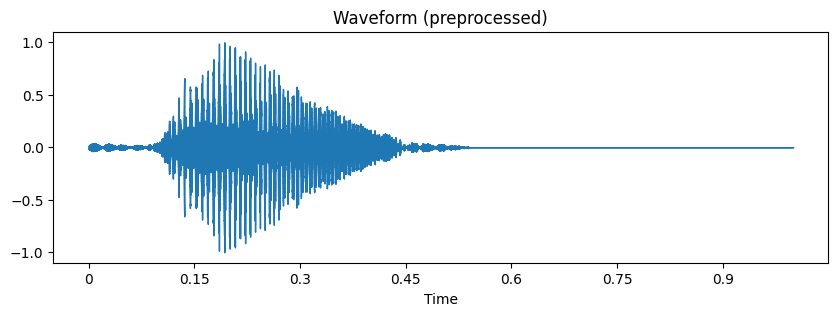

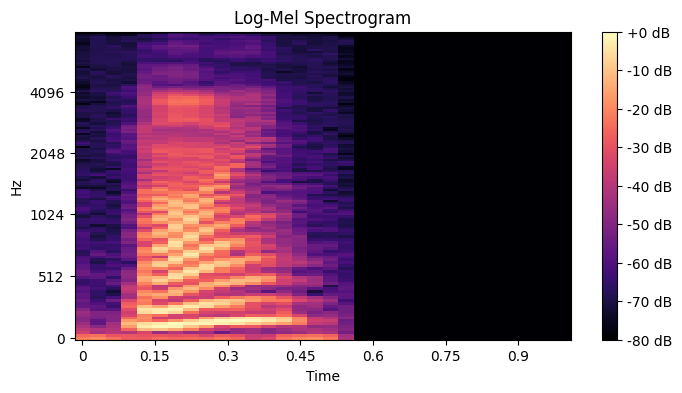

In [15]:
# Test on one random file
sample_path = random.choice(df['path'].tolist())
y, sr = load_and_preprocess(sample_path)
logmel = to_logmel(y, sr)

print(f"Sample path: {sample_path}")
print(f"Wave shape: {y.shape}, log-Mel shape: {logmel.shape}")

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform (preprocessed)")
plt.show()

plt.figure(figsize=(8, 4))
librosa.display.specshow(logmel, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title("Log-Mel Spectrogram")
plt.show()